# Training of UNET

The aim of this notebook is to train two times the UNET model, once using the training data with simple data augmentations (rotation by multiples of 90 degrees, horizontal and vertical flips), and the second time with said data augmentation and distortions added to the training data (non-uniform illumination and gaussian noise).

### $\bullet$ Importing libraries and utilitary functions

In [1]:
# Import python libraries.
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
%load_ext autoreload
%autoreload 2
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '1'
import tensorflow
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Import utilitary functions and module defining the Unet model.
from utils import get_dataset_from_folders
from train_data_augmentation import make_train_generator
import model
from distortions import add_gaussian, add_gaussian_noise
from plots import plot_history

In [2]:
# Set seeds of random number generators to guarantee reproducibility.
np.random.seed(1)
tensorflow.random.set_seed(2)

### $\bullet$ Setting size of the input image and different paths

In [3]:
# Shape of the inputs of the deep network.
images_shape = (256, 256, 1)

# Variables defining the path to the dataset.
train_input_path = '../Dataset/train/input/'
train_output_path = '../Dataset/train/output/'
val_input_path = '../Dataset/validation/input/'
val_output_path = '../Dataset/validation/output/'
test_input_path = '../Dataset/test/input/'
test_output_path = '../Dataset/test/output/'

# Variable defining where models will be stored.
model_original_save_path = "../Model Original/"
model_retrained_save_path = "../Model Retrained/"

### $\bullet$ Load images from the dataset

In [4]:
train_images, train_masks = get_dataset_from_folders(train_input_path, train_output_path, images_shape)
val_images, val_masks = get_dataset_from_folders(val_input_path, val_output_path, images_shape)
test_images, test_masks = get_dataset_from_folders(test_input_path, test_output_path, images_shape)

print(f'Training set contains {len(train_images)} images.')
print(f'Validation set contains {len(val_images)} images.')
print(f'Test set contains {len(test_images)} images.')

Training set contains 606 images.
Validation set contains 96 images.
Test set contains 510 images.


### $\bullet$ Choose training parameters and build model

In [5]:
# Setting up parameters used for training
number_epochs = 200
batch_size = 2
steps_per_epoch = np.ceil(len(train_images)/batch_size).astype(np.uint)
early_stopping = EarlyStopping(patience=80, verbose=1, restore_best_weights=True)
model_checkpoint = ModelCheckpoint(filepath=model_original_save_path, save_weights_only=False, monitor='val_accuracy', mode='max', save_best_only=True)

# Building Unet model.
unet = model.unet(images_shape, show_summary=True)

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 1) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 16) 160         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 256, 16) 2320        conv2d[0][0]                     
__________________________________________________________________________________________________
dropout (Dropout)               (None, 256, 256, 16) 0           conv2d_1[0][0]                   
______________________________________________________________________________________________

### Training model using images with simple data augmentations and no distortions

In [6]:
# Training
train_generator = make_train_generator(train_images, train_masks, batch_size=batch_size, custom_distortions=False)
history = unet.fit(train_generator, validation_data=(val_images, val_masks), steps_per_epoch=steps_per_epoch, batch_size=batch_size, epochs=number_epochs, callbacks=[early_stopping, model_checkpoint])

  ...
    to  
  ['...']
Train for 303 steps, validate on 96 samples
Epoch 1/200
302/303 [============================>.] - ETA: 0s - loss: 0.9445 - accuracy: 0.9400WARNING:tensorflow:From C:\Anaconda3\lib\site-packages\tensorflow_core\python\ops\resource_variable_ops.py:1786: calling BaseResourceVariable.__init__ (from tensorflow.python.ops.resource_variable_ops) with constraint is deprecated and will be removed in a future version.
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: ../Model Original/assets
303/303 [==============================] - 24s 80ms/step - loss: 0.9417 - accuracy: 0.9401 - val_loss: 0.0639 - val_accuracy: 0.9758
Epoch 2/200
303/303 [==============================] - 20s 65ms/step - loss: 0.0670 - accuracy: 0.9745 - val_loss: 0.0508 - val_accuracy: 0.9804
Epoch 3/200
303/303 [==============================] - 20s 67ms/step - loss: 0.0574 - accuracy: 0.9778 - val_loss: 0.0482 - val_accuracy: 0.981

303/303 [==============================] - 16s 54ms/step - loss: 0.0273 - accuracy: 0.9891 - val_loss: 0.0419 - val_accuracy: 0.9845
Epoch 43/200
303/303 [==============================] - 16s 54ms/step - loss: 0.0267 - accuracy: 0.9893 - val_loss: 0.0420 - val_accuracy: 0.9847
Epoch 44/200
303/303 [==============================] - 16s 54ms/step - loss: 0.0263 - accuracy: 0.9895 - val_loss: 0.0454 - val_accuracy: 0.9843
Epoch 45/200
303/303 [==============================] - 16s 54ms/step - loss: 0.0262 - accuracy: 0.9895 - val_loss: 0.0420 - val_accuracy: 0.9845
Epoch 46/200
303/303 [==============================] - 16s 54ms/step - loss: 0.0261 - accuracy: 0.9895 - val_loss: 0.0403 - val_accuracy: 0.9847
Epoch 47/200
303/303 [==============================] - 21s 69ms/step - loss: 0.0257 - accuracy: 0.9897 - val_loss: 0.0398 - val_accuracy: 0.9855
Epoch 48/200
303/303 [==============================] - 16s 53ms/step - loss: 0.0254 - accuracy: 0.9898 - val_loss: 0.0418 - val_accuracy

303/303 [==============================] - 17s 55ms/step - loss: 0.0202 - accuracy: 0.9916 - val_loss: 0.0443 - val_accuracy: 0.9851
Epoch 97/200
303/303 [==============================] - 17s 55ms/step - loss: 0.0202 - accuracy: 0.9917 - val_loss: 0.0465 - val_accuracy: 0.9845
Epoch 98/200
303/303 [==============================] - 17s 55ms/step - loss: 0.0202 - accuracy: 0.9916 - val_loss: 0.0438 - val_accuracy: 0.9855
Epoch 99/200
303/303 [==============================] - 17s 56ms/step - loss: 0.0202 - accuracy: 0.9917 - val_loss: 0.0449 - val_accuracy: 0.9848
Epoch 100/200
303/303 [==============================] - 17s 55ms/step - loss: 0.0200 - accuracy: 0.9917 - val_loss: 0.0460 - val_accuracy: 0.9847
Epoch 101/200
303/303 [==============================] - 17s 55ms/step - loss: 0.0198 - accuracy: 0.9918 - val_loss: 0.0451 - val_accuracy: 0.9852
Epoch 102/200
303/303 [==============================] - 17s 56ms/step - loss: 0.0203 - accuracy: 0.9917 - val_loss: 0.0438 - val_accur

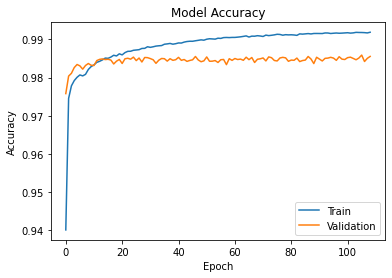

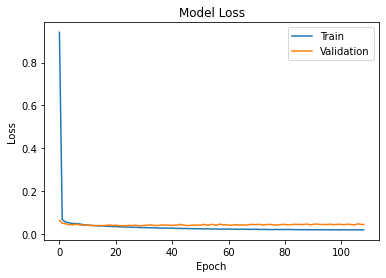

In [7]:
plot_history(history)

In [8]:
unet.evaluate(test_images, test_masks);

510/510 [==============================] - 6s 12ms/sample - loss: 0.0256 - accuracy: 0.9903


### Training model using images with simple data augmentations as well as distortions

In [9]:
# Setting up parameters used for training
number_epochs = 200
batch_size = 2
steps_per_epoch = np.ceil(len(train_images)/batch_size).astype(np.uint)
early_stopping = EarlyStopping(patience=80, verbose=1, restore_best_weights=True)
model_checkpoint = ModelCheckpoint(filepath=model_retrained_save_path, save_weights_only=False, monitor='val_accuracy', mode='max', save_best_only=True)

# Building Unet model.
unet = model.unet(images_shape, show_summary=False)

In [10]:
# Training
train_generator = make_train_generator(train_images, train_masks, batch_size=batch_size, custom_distortions=True)
history = unet.fit(train_generator, validation_data=(val_images, val_masks), steps_per_epoch=steps_per_epoch, batch_size=batch_size, epochs=number_epochs, callbacks=[early_stopping, model_checkpoint])

  ...
    to  
  ['...']
Train for 303 steps, validate on 96 samples
Epoch 1/200
303/303 [==============================] - 22s 74ms/step - loss: 0.4196 - accuracy: 0.9082 - val_loss: 0.1222 - val_accuracy: 0.9617
Epoch 2/200
303/303 [==============================] - 20s 67ms/step - loss: 0.2010 - accuracy: 0.9282 - val_loss: 0.1050 - val_accuracy: 0.9723
Epoch 3/200
303/303 [==============================] - 16s 53ms/step - loss: 0.1931 - accuracy: 0.9316 - val_loss: 0.1122 - val_accuracy: 0.9717
Epoch 4/200
303/303 [==============================] - 21s 69ms/step - loss: 0.1779 - accuracy: 0.9381 - val_loss: 0.0747 - val_accuracy: 0.9763
Epoch 5/200
303/303 [==============================] - 16s 53ms/step - loss: 0.1885 - accuracy: 0.9344 - val_loss: 0.1007 - val_accuracy: 0.9723
Epoch 6/200
303/303 [==============================] - 16s 54ms/step - loss: 0.1702 - accuracy: 0.9424 - val_loss: 0.1040 - val_accuracy: 0.9697
Epoch 7/200
303/303 [==============================] - 21s 69

303/303 [==============================] - 17s 55ms/step - loss: 0.1684 - accuracy: 0.9460 - val_loss: 0.0797 - val_accuracy: 0.9822
Epoch 46/200
303/303 [==============================] - 17s 55ms/step - loss: 0.1536 - accuracy: 0.9521 - val_loss: 0.0705 - val_accuracy: 0.9827
Epoch 47/200
303/303 [==============================] - 17s 55ms/step - loss: 0.1681 - accuracy: 0.9463 - val_loss: 0.0735 - val_accuracy: 0.9830
Epoch 48/200
303/303 [==============================] - 17s 55ms/step - loss: 0.1669 - accuracy: 0.9468 - val_loss: 0.0757 - val_accuracy: 0.9787
Epoch 49/200
303/303 [==============================] - 17s 55ms/step - loss: 0.1668 - accuracy: 0.9467 - val_loss: 0.0690 - val_accuracy: 0.9832
Epoch 50/200
303/303 [==============================] - 21s 70ms/step - loss: 0.1733 - accuracy: 0.9438 - val_loss: 0.0699 - val_accuracy: 0.9838
Epoch 51/200
303/303 [==============================] - 16s 53ms/step - loss: 0.1655 - accuracy: 0.9473 - val_loss: 0.0683 - val_accuracy

303/303 [==============================] - 16s 54ms/step - loss: 0.1624 - accuracy: 0.9494 - val_loss: 0.0660 - val_accuracy: 0.9833
Epoch 98/200
303/303 [==============================] - 16s 54ms/step - loss: 0.1594 - accuracy: 0.9505 - val_loss: 0.0668 - val_accuracy: 0.9832
Epoch 99/200
303/303 [==============================] - 16s 54ms/step - loss: 0.1644 - accuracy: 0.9483 - val_loss: 0.0884 - val_accuracy: 0.9827
Epoch 100/200
303/303 [==============================] - 16s 54ms/step - loss: 0.1622 - accuracy: 0.9494 - val_loss: 0.0834 - val_accuracy: 0.9839
Epoch 101/200
303/303 [==============================] - 16s 54ms/step - loss: 0.1734 - accuracy: 0.9446 - val_loss: 0.0958 - val_accuracy: 0.9812
Epoch 102/200
303/303 [==============================] - 16s 54ms/step - loss: 0.1613 - accuracy: 0.9497 - val_loss: 0.0849 - val_accuracy: 0.9807
Epoch 103/200
303/303 [==============================] - 16s 54ms/step - loss: 0.1657 - accuracy: 0.9478 - val_loss: 0.0744 - val_accu

Epoch 151/200
303/303 [==============================] - 16s 54ms/step - loss: 0.1616 - accuracy: 0.9501 - val_loss: 0.0718 - val_accuracy: 0.9829
Epoch 152/200
303/303 [==============================] - 16s 54ms/step - loss: 0.1667 - accuracy: 0.9479 - val_loss: 0.0772 - val_accuracy: 0.9837
Epoch 153/200
303/303 [==============================] - 16s 54ms/step - loss: 0.1588 - accuracy: 0.9510 - val_loss: 0.0656 - val_accuracy: 0.9839
Epoch 154/200
303/303 [==============================] - 17s 55ms/step - loss: 0.1601 - accuracy: 0.9504 - val_loss: 0.0770 - val_accuracy: 0.9840
Epoch 155/200
303/303 [==============================] - 17s 55ms/step - loss: 0.1656 - accuracy: 0.9484 - val_loss: 0.0749 - val_accuracy: 0.9844
Epoch 156/200
303/303 [==============================] - 17s 55ms/step - loss: 0.1642 - accuracy: 0.9488 - val_loss: 0.0775 - val_accuracy: 0.9841
Epoch 157/200
303/303 [==============================] - 21s 70ms/step - loss: 0.1582 - accuracy: 0.9512 - val_loss: 0

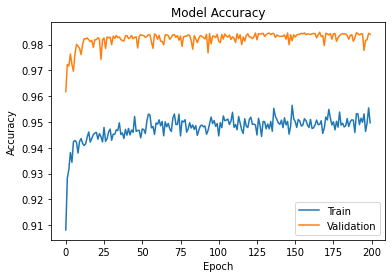

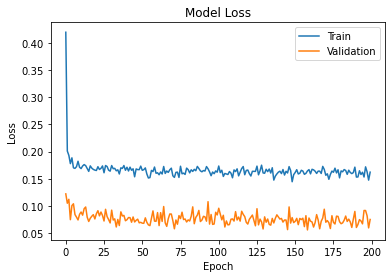

In [11]:
plot_history(history)

In [12]:
unet.evaluate(test_images, test_masks);

510/510 [==============================] - 4s 7ms/sample - loss: 0.0578 - accuracy: 0.9892
